In [2]:

import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
#peaks_3D('FA_20231113_2H_yeast_Pyruvate-d3_1.csv', 75)


In [4]:
from matplotlib import gridspec

def peaks_3D(filename, threshold_percentile):
    # Daten einlesen
    data = pd.read_csv(f"../Data/{filename}")

    chem_shifts = data.iloc[:, 0].values
    intensity_matrix = data.iloc[:, 1:].values.T

    # Setze GridSpec Layout
    fig = plt.figure(figsize=(14, 20))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05], height_ratios=[1, 3], hspace=0.05)

    # Erzeuge Axes für den Hauptplot und die Colorbar
    ax0 = plt.subplot(gs[0, 0])  # Hauptplot
    ax1 = plt.subplot(gs[1, 0], sharex=ax0)  # Zweiter Plot, teilt sich die x-Achse mit ax0
    cax = plt.subplot(gs[0, 1])  # Colorbar neben dem Hauptplot

    # Farbdarstellung der Intensität im Hauptplot
    c = ax0.imshow(intensity_matrix, aspect='auto', origin='lower',
                   extent=[chem_shifts.min(), chem_shifts.max(), 0, intensity_matrix.shape[0]], 
                   cmap='viridis')

    # Füge Colorbar hinzu
    plt.colorbar(c, cax=cax, label='Intensity')
    
    ax0.set_ylabel('Time/Spektrum Number')
    
    all_peak_positions = []

    # Finde und zeichne Peaks
    for i in range(intensity_matrix.shape[0]):
        intensity = intensity_matrix[i, :]

        threshold = np.percentile(intensity, threshold_percentile)
        first_derivative = np.gradient(intensity, chem_shifts)
        second_derivative = np.gradient(first_derivative, chem_shifts)
        third_derivative = np.gradient(second_derivative, chem_shifts)
        fourth_derivative = np.gradient(third_derivative, chem_shifts)

        sign_change = np.diff(np.sign(third_derivative)) != 0
        peak_mask = (intensity > threshold) & (second_derivative < 0) & (fourth_derivative > 0)
        peak_mask[1:] &= sign_change

        peak_pos = chem_shifts[peak_mask]
        all_peak_positions.extend(peak_pos)

        ax0.scatter(peak_pos, [i] * len(peak_pos), c='r', marker='.')

    # Zähle die Häufigkeiten der Peak-Positionen und bereite das Liniendiagramm vor
    peak_positions_counted = Counter(all_peak_positions)
    sorted_peak_positions = sorted(peak_positions_counted.items())
    xs, ys = zip(*sorted_peak_positions)

    # Linediagramm-Subplot für Peak-Positionen
    ax1.plot(xs, ys, '-o', color='blue')
    ax1.set_xlabel('Chem Shift')
    ax1.set_ylabel('Häufigkeit')
    ax1.set_title('Häufigkeit der Peak-Positionen als Liniendiagramm')



In [5]:
#peaks_3D('FA_20231113_2H_yeast_Pyruvate-d3_1.csv', 80)


In [6]:
def peak_fit(spectra_data, chem_shifts, threshold_percentile):
    """calculates possible peaks as minima in the second derivativeand returns list of peaks

    Args:
        spectra_data (_type_): x data of spectra
        chem_shifts (_type_): y data of spectra
        threshold_percentile (int | float): Threshold above which the relevant data lies

    Returns:
        list: peak positions
    """
    threshold = np.percentile(spectra_data, threshold_percentile)
    first_derivative = np.gradient(spectra_data, chem_shifts)
    second_derivative = np.gradient(first_derivative, chem_shifts)
    third_derivative = np.gradient(second_derivative, chem_shifts)
    fourth_derivative = np.gradient(third_derivative, chem_shifts)

    sign_change = np.diff(np.sign(third_derivative)) != 0
    peak_mask = (spectra_data > threshold) & (second_derivative < 0) & (fourth_derivative > 0)
    peak_mask[1:] &= sign_change

    return chem_shifts[peak_mask]


def peakfit_sum(filename, threshold_percentile):
    """sums up all spectra and visualises it with possible metabolite peaks

    Args:
        filename (str): file with spectra data
        threshold_percentile (int | float): Threshold above which the relevant data lies
    """
    data = pd.read_csv(f"../Data/{filename}")
    chem_shifts = data.iloc[:, 0].values
    intensity_matrix = data.iloc[:, 1:].values.T
    
    sum_of_spectra = np.sum(intensity_matrix, axis=0)
    peak_pos = peak_fit(sum_of_spectra, chem_shifts, threshold_percentile)
    
    plt.figure()
    plt.plot(chem_shifts, sum_of_spectra, label='Summe der Spektren')
    #plt.scatter(peak_pos, [sum_of_spectra[chem_shifts == pos] for pos in peak_pos], c='r', marker='.')
    for pos in peak_pos:
            plt.axvline(pos, color='red', linewidth=0.5)
    plt.axhline(np.percentile(sum_of_spectra, threshold_percentile), color='grey', linewidth=0.5)
    plt.xlabel('Chem Shift')
    plt.ylabel('Intensitätssumme')
    plt.legend()
    plt.title('Summe aller Spektren mit Peaks')
    plt.show()


def peakfit_3D(filename, threshold_percentile):
    """creates heatmap of all spectra in the experiment with markers for possible metabolite peaks

    Args:
        filename (str): file with spectra data
        threshold_percentile (int | float): Threshold above which the relevant data liesthreshold_percentile

    Returns:
        list, fig: list of all peak positions and visualisation
    """
    data = pd.read_csv(f"../Data/{filename}")
    chem_shifts = data.iloc[:, 0].values
    intensity_matrix = data.iloc[:, 1:].values.T
    
    fig = plt.figure(figsize=(14, 25))
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.05], height_ratios=[3, 1, 1], hspace=0.3)
    ax0 = plt.subplot(gs[0, 0])
    cax = plt.subplot(gs[0, 1])
    
    c = ax0.imshow(intensity_matrix, aspect='auto', origin='lower', extent=[chem_shifts.min(), chem_shifts.max(), 0, intensity_matrix.shape[0]], cmap='viridis')
    plt.colorbar(c, cax=cax, label='Intensity')

    all_peak_positions = []
    for i in range(intensity_matrix.shape[0]):
        peak_pos = peak_fit(intensity_matrix[i, :], chem_shifts, threshold_percentile)
        all_peak_positions.extend(peak_pos)
        ax0.scatter(peak_pos, [i] * len(peak_pos), c='r', marker='.')

    return all_peak_positions, fig

def peak_hist(peak_data):
    """creates histogramm based on all peak positions

    Args:
        peak_data (list): list of all peak positions
    """
    bin_size = 0.25
    plt.figure()
    plt.hist(peak_data, bins=np.arange(min(peak_data), max(peak_data) + bin_size, bin_size), color='blue', alpha=0.7)
    plt.xlabel('Chem Shift')
    plt.ylabel('Häufigkeit')
    plt.title('Histogramm der Peak-Positionen')
    plt.show()


In [7]:
def peaks_3D(filename, threshold_percentile):
    all_peak_positions, _ = peakfit_3D(filename, threshold_percentile)
    peakfit_sum(filename, threshold_percentile)
    peak_hist(all_peak_positions)

In [8]:
def composite_plot(filename, threshold_percentile):
    data = pd.read_csv(f"../Data/{filename}")
    chem_shifts = data.iloc[:, 0].values
    intensity_matrix = data.iloc[:, 1:].values.T
    
    # create plot layout
    fig = plt.figure(figsize=(10, 12))
    gs = gridspec.GridSpec(4, 2, figure=fig, width_ratios=[20, 1], height_ratios=[1, 1, 1, 1], hspace=0.05, wspace=0.02)
    ax_sum = fig.add_subplot(gs[0, 0])
    ax_3d = fig.add_subplot(gs[1:3, 0], sharex = ax_sum)
    ax_hist = fig.add_subplot(gs[3, 0], sharex=ax_3d)
    cax = fig.add_subplot(gs[1:3, 1])
    
    plt.setp(ax_sum.get_xticklabels(), visible=False)
    plt.setp(ax_3d.get_xticklabels(), visible=False)

    #create heatmap
    all_peak_positions = []
    for i in range(intensity_matrix.shape[0]):
        peak_pos = peak_fit(intensity_matrix[i, :], chem_shifts, threshold_percentile)
        all_peak_positions.extend(peak_pos)
        ax_3d.scatter(peak_pos, [i]*len(peak_pos), color='red', s=10)  # Zeitindex i mit s als Größe des Markers
    
    #add colorbar
    c = ax_3d.imshow(intensity_matrix, aspect='auto', origin='lower', extent=[chem_shifts.min(), chem_shifts.max(), 0, intensity_matrix.shape[0]], cmap='viridis')
    fig.colorbar(c, cax=cax, orientation='vertical', label='Intensity')
    ax_3d.set_ylabel('Time/spectrum number')
    
    #histogramm
    bin_size = 0.025
    if all_peak_positions:
        ax_hist.hist(all_peak_positions, bins=np.arange(min(all_peak_positions), max(all_peak_positions) + bin_size, bin_size), color='blue', alpha=0.7)
    ax_hist.set_xlabel('Chem Shift')
    ax_hist.set_ylabel('Occurence of recognized peaks')

    
    #sum of spectra
    sum_of_spectra = np.sum(intensity_matrix, axis=0)
    peak_pos = peak_fit(sum_of_spectra, chem_shifts, threshold_percentile)
    ax_sum.plot(chem_shifts, sum_of_spectra)

    for pos in peak_pos:
            ax_sum.axvline(pos, color='red', linewidth=0.5) 
    ax_sum.axhline(np.percentile(sum_of_spectra, threshold_percentile), color='grey', linewidth=0.5) 
    ax_sum.set_ylabel('Sum of Spectra Intensity')
   

    plt.show()

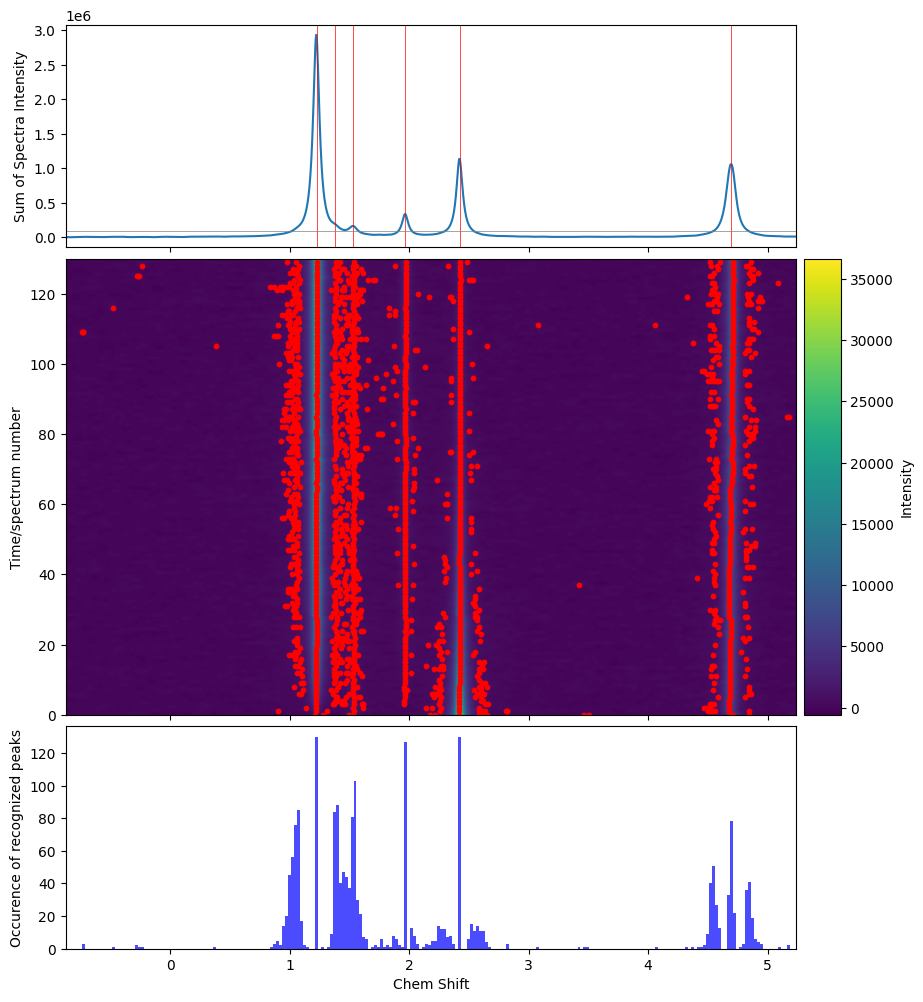

In [9]:
composite_plot('FA_20231113_2H_yeast_Pyruvate-d3_1.csv', 80)


# Zusätzlich einbringbare Relevanzkriterien:
- Peaks in folge über Zeit 
- Höhe der Peaks
klar abgetrennt ? -_> Silhouette score, muss alld dann erst nach binning
- Auftreten in Summierten peaks?  
   
- visualization of single spectra?

--> why does every significant peak has several recognized points left and right, is 2nd derivative correct? Is it of chemivcal origin? 

## add visualization of several single spectra --> check relevance

# get impression of data; visualize every 20th spectra 
plt.figure(figsize=(10, 6))

for i in range(1,len(data.columns), 20):
    sns.lineplot(x=data.iloc[:, 0], y=data.iloc[:, i], label=f'{i}')

plt.xlabel( 'chemical shift')
plt.ylabel('Intensity')
plt.legend(title='shown columns')
plt.show()

In [27]:
def composite_plot(filename, threshold_percentile):
    # define/get relevant data 
    data = pd.read_csv(f"../Data/{filename}")
    chem_shifts = data.iloc[:, 0].values
    intensity_matrix = data.iloc[:, 1:].values.T
    
    # create plot layout
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(5, 2, figure=fig, width_ratios=[20, 1], height_ratios=[1, 1, 0.5, 0.5,1], hspace=0.05, wspace=0.02)
    ax_singlet = fig.add_subplot(gs[0,0])
    ax_sum = fig.add_subplot(gs[1, 0], sharex= ax_singlet)

    ax_3d = fig.add_subplot(gs[2:4, 0], sharex = ax_sum)
    cax = fig.add_subplot(gs[2:4, 1])
    ax_hist = fig.add_subplot(gs[4, 0], sharex=ax_3d)
    
    
    plt.setp(ax_sum.get_xticklabels(), visible=False)
    plt.setp(ax_3d.get_xticklabels(), visible=False)

    #spectra singlets
    for i in range(0, intensity_matrix.shape[0], 5):  # Wählt jedes 20. Spektrum
        ax_singlet.plot(chem_shifts, intensity_matrix[i, :], label=f"Spectrum {i}")
    ax_singlet.legend(loc='upper right')
    ax_singlet.set_ylabel('Singlet Spectrum Intensity')

    #sum of spectra
    sum_of_spectra = np.sum(intensity_matrix, axis=0)
    peak_pos = peak_fit(sum_of_spectra, chem_shifts, threshold_percentile)
    ax_sum.plot(chem_shifts, sum_of_spectra)
    print(peak_pos)

    for pos in peak_pos:
            ax_sum.axvline(pos, color='red', linewidth=0.5) 
    ax_sum.axhline(np.percentile(sum_of_spectra, threshold_percentile), color='grey', linewidth=0.5) 
    ax_sum.set_ylabel('Sum of Spectra Intensity')
    print(peak_pos)
   
    #create heatmap
    all_peak_positions = []
    for i in range(intensity_matrix.shape[0]):
        peak_pos = peak_fit(intensity_matrix[i, :], chem_shifts, threshold_percentile)
        all_peak_positions.extend(peak_pos)
        ax_3d.scatter(peak_pos, [i]*len(peak_pos), color='red', s=10)  # Zeitindex i mit s als Größe des Markers
    
    #add colorbar
    c = ax_3d.imshow(intensity_matrix, aspect='auto', origin='lower', extent=[chem_shifts.min(), chem_shifts.max(), 0, intensity_matrix.shape[0]], cmap='viridis')
    fig.colorbar(c, cax=cax, orientation='vertical', label='Intensity')
    ax_3d.set_ylabel('Time/spectrum number')
    
    #histogramm
    bin_size = 0.025
    if all_peak_positions:
        ax_hist.hist(all_peak_positions, bins=np.arange(min(all_peak_positions), max(all_peak_positions) + bin_size, bin_size), color='blue', alpha=0.7)
    ax_hist.set_xlabel('Chem Shift')
    ax_hist.set_ylabel('Occurence of recognized peaks')

    plt.show()

[1.22618 1.37686 1.53162 1.96738 2.4235  4.69597]
[1.22618 1.37686 1.53162 1.96738 2.4235  4.69597]


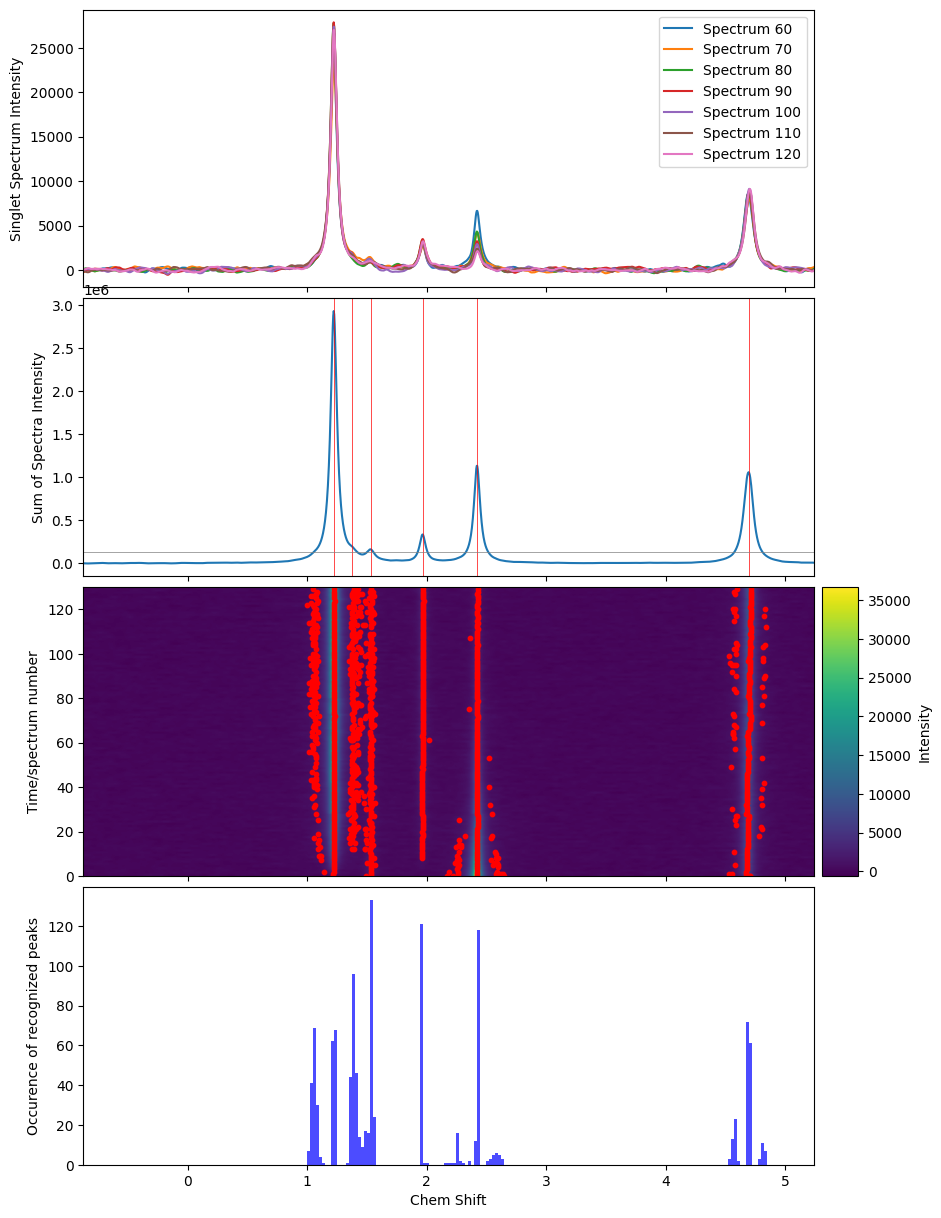

In [24]:
composite_plot('FA_20231113_2H_yeast_Pyruvate-d3_1.csv', 85)
# metabolite peaks supposedlxy at 1.2261, 1.9775
# substrate peak at 2.468

ph increases --> only Pyr-d3 present. Before that, switching Pyr-OH around 2.5
teh smaller ones don't matter --> noise

[4.5779  7.56713 8.27575 8.63413 8.72373 8.94365]
[4.5779  7.56713 8.27575 8.63413 8.72373 8.94365]


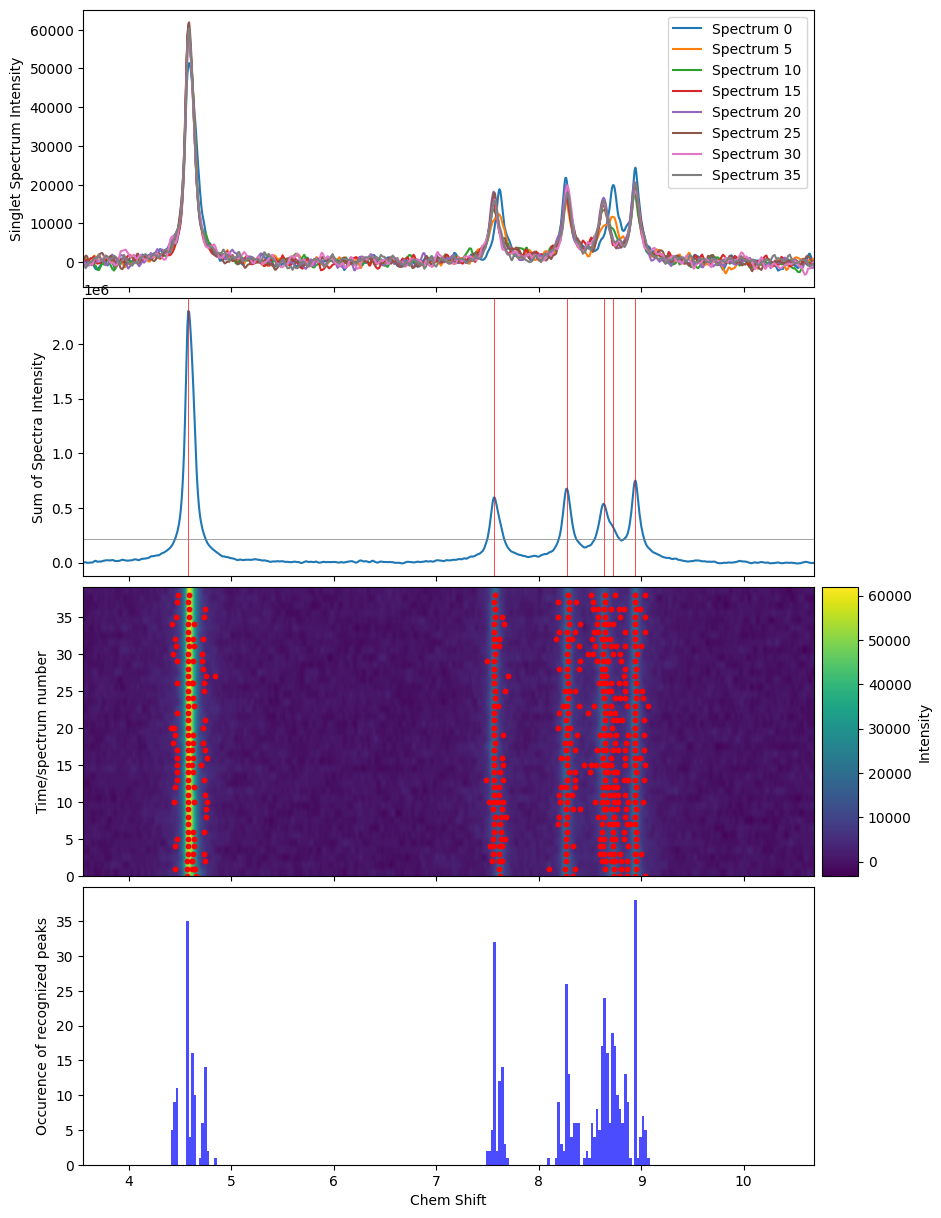

In [28]:
composite_plot('FA_20240108_2H_yeast_Nicotinamide-d4 _11.csv', 85)


In [13]:
# compare to metabolite

Options to continue:
- compare with seen peaks

-always check in range around expected peak, if there is one, if yes take biggest one. --> range depoendent in closest peaks
- do so for all spectra over time --> 
